In [7]:
import os
import math
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lib.datasets.synthetic as synthetic
import torchvision
import lib.datasets.maze as maze
import lib.datasets.mnist as mnist
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.loggers.loggers as loggers
import lib.loggers.logger_utils as logger_utils
from lib.models.models import UniformRate, UniformVariantRate, GaussianTargetRate
import lib.utils.utils as utils
import numpy as np
from lib.datasets import dataset_utils
from torch.utils.data import Dataset, DataLoader


def show_images(images, n=8, figsize=(10, 1), title='mazes.png'):
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).numpy().astype("uint8"), cmap="gray")
        plt.axis("off")
    plt.savefig(title)
    plt.show()
    #plt.close()



def plot_samples(samples, im_size=0, axis=False, im_fmt=None):
    """Plot samples."""
    plt.scatter(samples[:, 0], samples[:, 1], marker=".")
    plt.axis("equal")
    if im_size > 0:
        plt.xlim(-im_size, im_size)
        plt.ylim(-im_size, im_size)
    if not axis:
        plt.axis("off")
    plt.show()
    plt.close()


# loss_res = np.load('loss_CatRM104999_hollow10MRRes.npy')
def apply_ema(signal, alpha):
    """
    Anwendung des Exponential Moving Average auf ein Signal.

    :param signal: Das Eingangssignal (Liste oder NumPy-Array).
    :param alpha: Der Glättungsfaktor. Niedrigere Werte glätten mehr, typisch zwischen 0 und 1.
    :return: Das geglättete Signal.
    """
    ema = [signal[0]]  # Startwert für EMA
    for i in range(1, len(signal)):
        ema.append(alpha * signal[i] + (1 - alpha) * ema[i - 1])
    return np.array(ema)


"""
res = loss_res[1000:105000]
sm = apply_ema(res, 0.0001)
plt.plot(sm)
plt.yscale('log')
plt.show()
"""


def plot_squared(n_samples, samples, save_location_png):
    fig = plt.figure(figsize=(9, 9))
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1, 2, 0)), cmap="gray")

    saving_plot_path = os.path.join(
        save_location_png,
        "mazes.png",
    )
    # plt.suptitle('Mazes', fontsize=16)
    # plt.subplots_adjust(top=0.85)
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)
    # plt.savefig(saving_plot_path)
    plt.show()
    plt.close()

In [8]:
from config.bin_mnist_config.config_tauUnet_binmnist import get_config

cfg = get_config()
device = cfg.device
device = "cuda"
cfg.data.name = 'BinMNIST'
mnist_dataset = dataset_utils.get_dataset(cfg, device, cfg.data.location)
cfg.data.batch_size = 10
mnist_dl = DataLoader(
    mnist_dataset, cfg.data.batch_size, shuffle=True, num_workers=0
)
# worker_init_fn=worker_init_fn)
#cfg.model.time_base = 3
#cfg.model.time_exp = 100
#cfg.model.rate_sigma = 6.0
#cfg.model.Q_sigma = 512.0

Time points tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
Prob tensor([[0.5051, 0.4949],
        [0.5051, 0.4949],
        [0.5051, 0.4949],
        ...,
        [0.5051, 0.4949],
        [0.5051, 0.4949],
        [0.5051, 0.4949]], device='cuda:0')


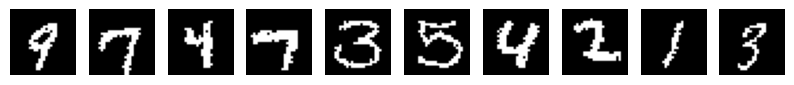

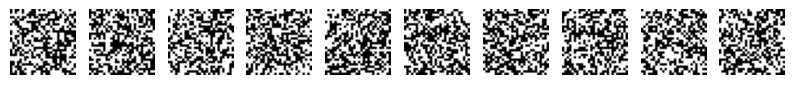

In [21]:
cfg.model.rate_const = 2.3 # 2.3 log_sqr t=0.5T 0.4763, 0.2619, 0.2619 [0.3511, 0.3245, 0.3245], [0.3444, 0.3278, 0.3278], [0.4763, 0.2619, 0.2619], 0.5557, 0.2221, 0.2221],
cfg.model.t_func = "sqrt_cos"  # sqrt_cos

# model = UniformRate(cfg, 'cuda')
model = UniformVariantRate(cfg, "cuda")
S = 2
# 0.25 [0.7867, 0.1116, 0.1116]
# 0.5 [0.4763, 0.2619, 0.2619
# 1 [0.3389, 0.3305, 0.3305],
ls = np.linspace(0.001, 1, 8)
tensor_list = []
for minibatch in mnist_dl:
    B, C, H, W = minibatch.shape
    D = C * H * W
    minibatch = minibatch.view(B, D)
    # ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
    ts = torch.ones((B,), device=device) * 1
    ts = torch.clamp(ts, max=0.99999)
    # ts = torch.linspace(0.01, 1, B, device=device)
    print("Time points", ts[:9])
    qt0 = model.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)
    b = utils.expand_dims(
        torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
    )
    qt0 = qt0[b, minibatch.long()].view(-1, S)
    print("Prob", qt0_rows_reg)  # , qt0)
    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

    rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]  # (B*D, S)

    rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

    rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

    #  Summe der Werte entlang der Dimension S
    rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
        B, D
    )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
    square_dimcat = torch.distributions.categorical.Categorical(
        rate_vals_square_dimsum
    )

    square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

    rate_new_val_probs = rate_vals_square[
        torch.arange(B, device=device), square_dims, :
    ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
    # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

    # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
    square_newvalcat = torch.distributions.categorical.Categorical(
        rate_new_val_probs
    )

    square_newval_samples = (
        square_newvalcat.sample()
    )  # (B, ) taking values in [0, S)

    x_tilde = x_t.clone()
    x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
    x_tilde = x_tilde.view(B, C, H, W)
    tensor_list.append(x_tilde)
    show_images(minibatch.view(B, C, H, W).detach().cpu(), n=B) # * 127.5
    show_images(x_tilde.detach().cpu() * 127.5, n=B) # * 127.5
    # noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    # show_images(noise_x.view(B, C, H, W).detach().cpu() * 127.5, n=B) # * 127.5
#tens = torch.stack(tensor_list, 0).to(device)
#tens[0] = minibatch.view(C, H, W)
#print(tens.shape)
#show_images(tens.detach().cpu(), n=len(ls))
    break

In [ ]:
import torch
from torch import nn
from einops.layers.torch import Rearrange
patch_size = 4
image_size_h = image_size_w = 28
num_patches = (image_size_h // patch_size) * (image_size_w // patch_size)
channels = 1
patch_dim = channels * patch_size ** 2
dim = patch_dim
seq = nn.Sequential(
    Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
   #nn.LayerNorm(patch_dim),
    nn.Linear(patch_dim, dim),
    #nn.LayerNorm(dim)
)
x = torch.randn(1, 1, 28, 28)
print(x)
print(seq(x))

In [ ]:
import torch

N = 1  # Anzahl der Matrizen
S = 3 # Anzahl der Zustände

# Erzeuge eine NxSxS-Matrix mit Nullen
state_change_matrix = torch.zeros(S, S)

# Fülle die Hauptdiagonale mit Nullen
state_change_matrix[torch.arange(S), torch.arange(S)] = 0

# Fülle die Werte über der Hauptdiagonalen (nach rechts)
for i in range(1, S):
    state_change_matrix[torch.arange(S - i), torch.arange(i, S)] = i

# Fülle die Werte unter der Hauptdiagonalen (nach links)
for i in range(1, S):
    state_change_matrix[torch.arange(i, S), torch.arange(S - i)] = -i
print(state_change_matrix)
B = 5
# print(torch.tile(state_change_matrix, (B, 1,1)).shape)
torch.save(state_change_matrix, 'state_change_matrix_maze.pth')

In [ ]:
loaded_matrix = torch.load('state_change_matrix_mnist.pth')
loaded_matrix = loaded_matrix.to('cuda')


In [ ]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    # Get information about each GPU
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No CUDA-compatible GPU found.")


In [ ]:
from config.mnist_config.config_hollow_mnist import get_config

cfg = get_config()
device = cfg.device
device = "cuda"
cfg.data.name = 'DiscreteCIFAR10'
mnist_dataset = dataset_utils.get_dataset(cfg, device, cfg.data.location)
cfg.data.batch_size = 1
mnist_dl = DataLoader(
    mnist_dataset, cfg.data.batch_size, shuffle=True, num_workers=0
)
# worker_init_fn=worker_init_fn)
#cfg.model.time_base = 3
#cfg.model.time_exp = 100
#cfg.model.rate_sigma = 6.0
#cfg.model.Q_sigma = 512.0


In [ ]:
cfg.model.rate_const = 0.012 # 2.3 log_sqr t=0.5T 0.4763, 0.2619, 0.2619 [0.3511, 0.3245, 0.3245], [0.3444, 0.3278, 0.3278], [0.4763, 0.2619, 0.2619], 0.5557, 0.2221, 0.2221],
cfg.model.t_func = "sqrt_cos"  # sqrt_cos

# model = UniformRate(cfg, 'cuda')
model = UniformVariantRate(cfg, "cuda")
S = 256
# 0.25 [0.7867, 0.1116, 0.1116]
# 0.5 [0.4763, 0.2619, 0.2619
# 1 [0.3389, 0.3305, 0.3305],
ls = np.linspace(0.001, 1, 8)
tensor_list = []
for minibatch in mnist_dl:
    B, C, H, W = minibatch.shape
    D = C * H * W
    for i in ls:
        minibatch = minibatch.view(B, D)
        # ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
        ts = torch.ones((B,), device=device) * i
        ts = torch.clamp(ts, max=0.99999)
        # ts = torch.linspace(0.01, 1, B, device=device)
        print("Time points", ts[:9])
        qt0 = model.transition(
            ts
        )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

        # R_t = beta_t * R_b
        rate = model.rate(
            ts
        )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

        qt0_rows_reg = qt0[
            torch.arange(B, device=device).repeat_interleave(
                D
            ),  # repeats every element 0 to B-1 D-times
            minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
            :,
        ]  # (B*D, S)
        b = utils.expand_dims(
            torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
        )
        qt0 = qt0[b, minibatch.long()].view(-1, S)
        print(qt0_rows_reg)  # , qt0)
        # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
        x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
        x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
            B, D
        )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

        rate_vals_square = rate[
            torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
        ]  # (B*D, S)

        rate_vals_square[
            torch.arange(B * D, device=device), x_t.long().flatten()
        ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

        rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

        #  Summe der Werte entlang der Dimension S
        rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
            B, D
        )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
        square_dimcat = torch.distributions.categorical.Categorical(
            rate_vals_square_dimsum
        )

        square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

        rate_new_val_probs = rate_vals_square[
            torch.arange(B, device=device), square_dims, :
        ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
        # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

        # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
        square_newvalcat = torch.distributions.categorical.Categorical(
            rate_new_val_probs
        )

        square_newval_samples = (
            square_newvalcat.sample()
        )  # (B, ) taking values in [0, S)

        x_tilde = x_t.clone()
        x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
        # x_tilde = x_tilde.view(B, C, H, W)
        x_tilde = x_tilde.view(C, H, W)
        tensor_list.append(x_tilde)
        # show_images(minibatch.view(B, C, H, W).detach().cpu()* 127.5, n=B) # * 127.5
        # show_images(x_tilde.detach().cpu() * 127.5, n=B) # * 127.5
        # noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
        # show_images(noise_x.view(B, C, H, W).detach().cpu() * 127.5, n=B) # * 127.5
    tens = torch.stack(tensor_list, 0).to(device)
    tens[0] = minibatch.view(C, H, W)
    print(tens.shape)
    show_images(tens.detach().cpu(), n=len(ls))
    break

In [ ]:
ls = np.linspace(0.001, 1, 10)
tensor_list = []
for i in ls:
    minibatch = minibatch.view(B, D)
    # ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
    ts = torch.ones((B,), device=device) * i
    ts = torch.clamp(ts, max=0.99999)
    # ts = torch.linspace(0.01, 1, B, device=device)
    print("Time points", ts[:9])
    qt0 = model.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)
    b = utils.expand_dims(
        torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
    )
    qt0 = qt0[b, minibatch.long()].view(-1, S)
    print(qt0_rows_reg)  # , qt0)
    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

    rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]  # (B*D, S)

    rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

    rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

    #  Summe der Werte entlang der Dimension S
    rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
        B, D
    )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
    square_dimcat = torch.distributions.categorical.Categorical(
        rate_vals_square_dimsum
    )

    square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

    rate_new_val_probs = rate_vals_square[
        torch.arange(B, device=device), square_dims, :
    ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
    # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

    # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
    square_newvalcat = torch.distributions.categorical.Categorical(
        rate_new_val_probs
    )

    square_newval_samples = (
        square_newvalcat.sample()
    )  # (B, ) taking values in [0, S)

    x_tilde = x_t.clone()
    x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
    # x_tilde = x_tilde.view(B, C, H, W)
    x_tilde = x_tilde.view(C, H, W)
    tensor_list.append(x_tilde)
    # show_images(minibatch.view(B, C, H, W).detach().cpu()* 127.5, n=B) # * 127.5
    # show_images(x_tilde.detach().cpu() * 127.5, n=B) # * 127.5
    # noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    # show_images(noise_x.view(B, C, H, W).detach().cpu() * 127.5, n=B) # * 127.5
tens = torch.stack(tensor_list, 0).to(device)
tens[0] = minibatch.view(C, H, W)
print(tens.shape)
show_images(tens.detach().cpu(), n=len(ls))


In [ ]:
def show_images2(images, n=8, figsize=(3, 3), title='mazes.png'):
    plt.figure(figsize=figsize)
    plt.imshow(images.permute(1, 2, 0).numpy().astype("uint64"), cmap="gray")
    plt.axis("off")
    plt.savefig(title)
    plt.close()
show_images2(tens[5].view(C, H, W).cpu(), n=1, title='middle_2.png')

In [ ]:
def show_images2(images, n=8, figsize=(3, 3), title='mazes.png'):
    plt.figure(figsize=figsize)
    plt.imshow(images.permute(1, 2, 0).numpy().astype("uint64"), cmap="gray")
    plt.axis("off")
    plt.savefig(title)
    plt.close()
show_images2(tens[0].view(C, H, W).detach().cpu(), n=1, title='true.png')
show_images2(tens[3].view(C, H, W).cpu(), n=1, title='middle.png')
show_images2(tens[-1].view(C, H, W).detach().cpu(), n=1, title='noisy.png')

In [ ]:
cfg.model.rate_const = 0.01 # 2.3 log_sqr t=0.5T 0.4763, 0.2619, 0.2619 [0.3511, 0.3245, 0.3245], [0.3444, 0.3278, 0.3278], [0.4763, 0.2619, 0.2619], 0.5557, 0.2221, 0.2221],
cfg.model.t_func = "sqrt_cos"  # sqrt_cos

# model = UniformRate(cfg, 'cuda')
model_2 = UniformRate(cfg, "cuda")
S = 256
# 0.25 [0.7867, 0.1116, 0.1116]
# 0.5 [0.4763, 0.2619, 0.2619
# 1 [0.3389, 0.3305, 0.3305],
ls = np.linspace(0.001, 1, 8)
tensor_list = []

for i in ls:
    minibatch = minibatch.view(B, D)
    # ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
    ts = torch.ones((B,), device=device) * i
    ts = torch.clamp(ts, max=0.99999)
    # ts = torch.linspace(0.01, 1, B, device=device)
    print("Time points", ts[:9])
    qt0 = model_2.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model_2.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)
    b = utils.expand_dims(
        torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
    )
    qt0 = qt0[b, minibatch.long()].view(-1, S)
    print(qt0_rows_reg)  # , qt0)
    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

    rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]  # (B*D, S)

    rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

    rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

    #  Summe der Werte entlang der Dimension S
    rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
        B, D
    )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
    square_dimcat = torch.distributions.categorical.Categorical(
        rate_vals_square_dimsum
    )

    square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

    rate_new_val_probs = rate_vals_square[
        torch.arange(B, device=device), square_dims, :
    ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
    # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

    # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
    square_newvalcat = torch.distributions.categorical.Categorical(
        rate_new_val_probs
    )

    square_newval_samples = (
        square_newvalcat.sample()
    )  # (B, ) taking values in [0, S)

    x_tilde = x_t.clone()
    x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
    # x_tilde = x_tilde.view(B, C, H, W)
    x_tilde = x_tilde.view(C, H, W)
    tensor_list.append(x_tilde)
    # show_images(minibatch.view(B, C, H, W).detach().cpu()* 127.5, n=B) # * 127.5
    # show_images(x_tilde.detach().cpu() * 127.5, n=B) # * 127.5
    # noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    # show_images(noise_x.view(B, C, H, W).detach().cpu() * 127.5, n=B) # * 127.5
tens = torch.stack(tensor_list, 0).to(device)
tens[0] = minibatch.view(C, H, W)
show_images(tens.detach().cpu(), n=len(ls))


In [ ]:
show_images(tens[0].detach().cpu(), n=1, title='true.png')
show_images(tens[3].detach().cpu(), n=1, title='middle.png')
show_images(tens[-1].detach().cpu(), n=1, title='noisy.png')

In [ ]:
seq_len = 10
device = "cuda"
att_l2r_mask = ~torch.triu(
    torch.ones((seq_len, seq_len), device=device, dtype=torch.bool),
    diagonal=1,
).unsqueeze(
    0
)  # 1, D, D

att_r2l_mask = ~torch.tril(
    torch.ones((seq_len, seq_len), device=device, dtype=torch.bool),
    diagonal=-1,
).unsqueeze(
    0
)  # 1, D, D


att_t = torch.ones((1, seq_len, 1), device=device)  # 1, D, 1

joint_mask = torch.cat([att_t, att_l2r_mask, att_r2l_mask], dim=-1).unsqueeze(
    0
)  # 1, 1, B, H*HD
# print("joint_maks", joint_mask.shape)
joint_mask = (joint_mask > 0) * 1
print(joint_mask, joint_mask.shape)


seq_len = 10
device = "cuda"
att_l2r_mask = ~torch.triu(
    torch.ones((seq_len, seq_len), device=device, dtype=torch.bool),
    diagonal=1,
)  # 1, D, D

att_r2l_mask = ~torch.tril(
    torch.ones((seq_len, seq_len), device=device, dtype=torch.bool),
    diagonal=-1,
)  # 1, D, D


att_t = torch.ones((seq_len, 1), device=device)  # 1, D, 1

joint_mask = torch.cat([att_t, att_l2r_mask, att_r2l_mask], dim=-1)  # 1, 1, B, H*HD
# print("joint_maks", joint_mask.shape)
joint_mask = joint_mask > 0
joint_mask = joint_mask.unsqueeze(0) * 1
print(joint_mask, joint_mask.shape)

In [ ]:
from flax import linen as nn
import jax
import jax.numpy as jnp

device = "cuda"
seq_len = 10
idx = jnp.arange(10, dtype=jnp.int32)
att_l2r_mask_jnp = nn.attention.make_attention_mask(idx, idx, jnp.greater_equal)

att_l2r_mask = ~torch.triu(
    torch.ones((seq_len, seq_len), device=device, dtype=torch.bool), diagonal=1
)
# print("torch", att_l2r_mask * 1)
# att_l2r_mask = ~att_l2r_mask


idx = jnp.arange(seq_len, dtype=jnp.int32)
att_l2r_mask = nn.attention.make_attention_mask(idx, idx, jnp.greater_equal)
att_r2l_mask = nn.attention.make_attention_mask(idx, idx, jnp.less_equal)
att_t = jnp.ones((1, seq_len, 1))
joint_mask = jnp.concatenate([att_t, att_l2r_mask, att_r2l_mask], axis=-1)
joint_mask = jnp.expand_dims(joint_mask, axis=0)
print(joint_mask, joint_mask.shape)

In [ ]:
pos_idx = jnp.expand_dims(jnp.arange(10, dtype=jnp.int32), 0)  # 1, D(+1)

mask_l2r_jnp = nn.attention.make_attention_mask(pos_idx, pos_idx, jnp.greater_equal)
print(mask_l2r_jnp, mask_l2r_jnp.shape)
mask_l2r_jnp = mask_l2r_jnp.at[:, :, :1, :1].set(1.0)
print(mask_l2r_jnp, mask_l2r_jnp.shape)
mask_l2r_torch = torch.triu(
    torch.ones((10, 10), device=device, dtype=torch.bool),
    diagonal=1,
)
mask_l2r_torch = torch.where(
    mask_l2r_torch, torch.tensor(float("-inf")), torch.tensor(0.0)
)
print(mask_l2r_torch, mask_l2r_torch.shape, mask_l2r_torch[5, 5])

In [ ]:
mask_l2r_jnp = torch.triu(
    torch.ones((10, 10), dtype=torch.bool),
    diagonal=1,  # concat_dim = D; if conditioner:
)
print(mask_l2r_jnp)
mask_l2r_jnp = torch.where(mask_l2r_jnp, torch.tensor(float("-inf")), torch.tensor(0.0))
att_r2l_mask = torch.tril(
    torch.ones((10, 10), dtype=torch.bool),
    diagonal=-1,
)
print(att_r2l_mask)

In [ ]:
mask_l2r_jnp = torch.full((10, 10), float("-inf"))
mask_l2r_jnp[:5, :5] = 0
print(mask_l2r_jnp)

In [ ]:
att = np.load("SavedModels/MAZE/PNGs/loss_CatRM23999_hollow14MRTAtt64.npy")
# res = np.load('loss_CatRM11999_hollow20MRes.npy')
att_10M = np.load("SavedModels/MAZE/PNGs/loss_CatRM11999_hollow14MRTAtt.npy")  # 93 000
att_emb = np.load("SavedModels/MAZE/PNGs/loss_CatRM5999_hollowMRTEmb.npy")
att_cos1 = np.load("SavedModels/MAZE/PNGs/loss_CatRM5999_hollowMRT14Cos.npy")
att_cos10l_15mlp = np.load("SavedModels/MAZE/PNGs/loss_CatRM5999.npy")

print(len(att_10M))
att = att[10000:12000]
print("att64", np.mean(att))
a = 1000
b = 6000
att_emb = att_emb[a:b]
print("EMB", np.mean(att_emb))
# print("Cos high LR", np.mean(att_cos_highlr))
att_cos1 = att_cos1[a:b]
print("Cos1", np.mean(att_cos1))
att_cos10l_15mlp = att_cos10l_15mlp[a:b]
print("Cos10L", np.mean(att_cos10l_15mlp))
att_10M = att_10M[a:b]
print("att128", np.mean(att_10M))

coff = 0.5

att_sm = apply_ema(att, 1)
att_cos1 = apply_ema(att_cos1, coff)
att10M_sm = apply_ema(att_10M, coff)
att_emb = apply_ema(att_emb, coff)
att_cos10l_15mlp = apply_ema(att_cos10l_15mlp, coff)
# plt.plot(att_sm, label='att 64B')
# plt.plot(att, label='att 64B')
plt.plot(att_emb, label="EMb")
plt.plot(att_cos1, label="Cos")
plt.plot(att_cos10l_15mlp, label="Cos 2e-4")
# plt.plot(att_10M, label='att 128B')
# plt.plot(att_sm, label='att 64B')
plt.plot(att10M_sm, label="att 128B")
# plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
##att_20MR = np.load('SavedModels/MAZE/PNGs/loss_CatRM5999.npy')
att_14MRT = np.load("SavedModels/MAZE/PNGs/loss_CatRM56999.npy")
# att_14MRT2 = np.load('SavedModels/MAZE/PNGs/loss_CatRM10999_hollowXtCos141e4.npy')
att_14MRT3 = np.load("SavedModels/MAZE/PNGs/loss_CatRM74999_hollowXtCos14.npy")

a = 25000
b = 56999
coff = 0.001

# att_20MR = att_20MR[a:b]
att_14MRT = att_14MRT[a:b]
# att_14MRT2 = att_14MRT2[a:b]
att_14MRT3 = att_14MRT3[a:b]
# att_20MR = apply_ema(att_20MR, coff)

att_14MRT = apply_ema(att_14MRT, coff)
# att_14MRT2 = apply_ema(att_14MRT2, coff)
att_14MRT3 = apply_ema(att_14MRT3, coff)
plt.plot(att_14MRT, label="RProb clip31.5e4")
# plt.plot(att_14MRT2, label='Cos right')
plt.plot(att_14MRT3, label="Cos wron 2e4")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
from config.maze_config.config_tauUnet_maze import get_config

cfg = get_config()
model = model_utils.create_model(cfg, cfg.device)
print("Number of Parameters: ", sum([p.numel() for p in model.parameters()]))

In [ ]:
loss_res = np.load("loss_CatRM104999_hollow10MRRes.npy")


def apply_ema(signal, alpha):
    """
    Anwendung des Exponential Moving Average auf ein Signal.

    :param signal: Das Eingangssignal (Liste oder NumPy-Array).
    :param alpha: Der Glättungsfaktor. Niedrigere Werte glätten mehr, typisch zwischen 0 und 1.
    :return: Das geglättete Signal.
    """
    ema = [signal[0]]  # Startwert für EMA
    for i in range(1, len(signal)):
        ema.append(alpha * signal[i] + (1 - alpha) * ema[i - 1])
    return np.array(ema)

In [ ]:
from config.maze_config.config_bert_maze import get_config

cfg = get_config()
model = model_utils.create_model(cfg, cfg.device)
print("Number of Parameters: ", sum([p.numel() for p in model.parameters()]))

In [ ]:
from lib.networks.ddsm_networks import ProteinScoreNet
from config.maze_config.config_hollow_maze import get_config

cfg = get_config()
cfg.device = "cuda"


D = cfg.model.concat_dim = 1024
S = cfg.data.S = 5
B = cfg.data.batch_size
net = ProteinScoreNet(cfg).to(cfg.device)
ts = torch.rand((B,), device=cfg.device) * (1.0 - 0.01) + 0.01
x = torch.randint(low=0, high=S, size=(B, D), device="cuda")
x_out = net(x, ts)
print(x_out.shape)

In [ ]:
from config.mnist_config.config_hollow_mnist import get_config

cfg = get_config()
device = cfg.device
device = "cuda"
cfg.data.name = 'DiscreteCIFAR10'
mnist_dataset = dataset_utils.get_dataset(cfg, device, cfg.data.location)
cfg.data.batch_size = 1
mnist_dl = DataLoader(
    mnist_dataset, cfg.data.batch_size, shuffle=cfg.data.shuffle, num_workers=0
)
# worker_init_fn=worker_init_fn)
#cfg.model.time_base = 3
#cfg.model.time_exp = 100
#cfg.model.rate_sigma = 6.0
#cfg.model.Q_sigma = 512.0

#model = GaussianTargetRate(cfg, device)

In [ ]:
from config.synthetic_config.config_ebm_synthetic import get_config

cfg = get_config()
location = "lib/datasets/Synthetic/data_2spirals.npy"
device = cfg.device
device = "cuda"
synthetic_dataset = dataset_utils.get_dataset(cfg, device, location)
cfg.data.batch_size = 1
synthetic_dl = DataLoader(
    synthetic_dataset, cfg.data.batch_size, shuffle=cfg.data.shuffle, num_workers=0
)
# worker_init_fn=worker_init_fn)

In [ ]:
cfg.model.rate_const = 2.5  # 0.00009
cfg.model.t_func = "log_sqr"
# model = UniformRate(cfg, device)
model = UniformVariantRate(cfg, device)
# model = GaussianTargetRate(cfg, device)
S = 2
bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
ls = np.linspace(0.001, 1, 10)
for minibatch in synthetic_dl:
    for i in ls:
        # print(minibatch.device)
        B, D = minibatch.shape
        minibatch = minibatch.view(B, D).to("cpu")
        ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
        ts = torch.ones((B,), device=device) * i
        print("Time points", ts[:9])

        qt0 = model.transition(
            ts
        )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

        # R_t = beta_t * R_b
        rate = model.rate(
            ts
        )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

        qt0_rows_reg = qt0[
            torch.arange(B, device=device).repeat_interleave(
                D
            ),  # repeats every element 0 to B-1 D-times
            minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
            :,
        ]  # (B*D, S)
        b = utils.expand_dims(
            torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
        )
        qt0 = qt0[b, minibatch.long()]
        print(qt0_rows_reg, qt0_rows_reg.shape)
        # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
        x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
        x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
            B, D
        )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

        rate_vals_square = rate[
            torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
        ]  # (B*D, S)

        rate_vals_square[
            torch.arange(B * D, device=device), x_t.long().flatten()
        ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

        rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

        #  Summe der Werte entlang der Dimension S
        rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
            B, D
        )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
        square_dimcat = torch.distributions.categorical.Categorical(
            rate_vals_square_dimsum
        )

        square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

        rate_new_val_probs = rate_vals_square[
            torch.arange(B, device=device), square_dims, :
        ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
        # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

        # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
        square_newvalcat = torch.distributions.categorical.Categorical(
            rate_new_val_probs
        )

        square_newval_samples = (
            square_newvalcat.sample()
        )  # (B, ) taking values in [0, S)

        x_tilde = x_t.clone()
        x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
        x_tilde = synthetic.bin2float(
            x_tilde.detach().cpu().numpy().astype(np.int32),
            inv_bm,
            cfg.model.concat_dim,
            cfg.data.int_scale,
        )

        # minibatch = synthetic.bin2float(minibatch.detach().cpu().numpy().astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
        # plot_samples(minibatch) # * 127.5
        # plot_samples(x_tilde) # * 127.5
        noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)

        # noise_x = synthetic.bin2float(noise_x.detach().cpu().numpy().astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)
        # plot_samples(noise_x) # * 127.5
    break

In [ ]:
cfg.model.rate_const = 0.1  # 0.00009
cfg.model.t_func = "log"

cfg.model.time_base = 3
cfg.model.time_exp = 100
cfg.model.rate_sigma = 6.0
cfg.model.Q_sigma = 512.0
# model = UniformRate(cfg, device)
model = UniformVariantRate(cfg, device)
# model = GaussianTargetRate(cfg, device)
S = 256


for minibatch in mnist_dl:
    B, C, H, W = minibatch.shape
    print(minibatch.device)
    D = C * H * W
    minibatch = minibatch.view(B, D).to("cpu")
    ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
    ts = torch.ones((B,), device=device) * 1
    print("Time points", ts[:9])

    qt0 = model.transition(
        ts
    )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

    # R_t = beta_t * R_b
    rate = model.rate(
        ts
    )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

    qt0_rows_reg = qt0[
        torch.arange(B, device=device).repeat_interleave(
            D
        ),  # repeats every element 0 to B-1 D-times
        minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
        :,
    ]  # (B*D, S)
    b = utils.expand_dims(
        torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
    )
    qt0 = qt0[b, minibatch.long()]
    print(qt0_rows_reg, qt0_rows_reg.shape)
    # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
    x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
    x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
        B, D
    )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

    rate_vals_square = rate[
        torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
    ]  # (B*D, S)

    rate_vals_square[
        torch.arange(B * D, device=device), x_t.long().flatten()
    ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

    rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

    #  Summe der Werte entlang der Dimension S
    rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
        B, D
    )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
    square_dimcat = torch.distributions.categorical.Categorical(rate_vals_square_dimsum)

    square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

    rate_new_val_probs = rate_vals_square[
        torch.arange(B, device=device), square_dims, :
    ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
    # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

    # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
    square_newvalcat = torch.distributions.categorical.Categorical(rate_new_val_probs)

    square_newval_samples = square_newvalcat.sample()  # (B, ) taking values in [0, S)

    x_tilde = x_t.clone()
    x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
    x_tilde = x_tilde.view(B, C, H, W)

    show_images(minibatch.view(B, C, H, W).detach().cpu(), n=9)  # * 127.5
    show_images(x_tilde.detach().cpu(), n=9)  # * 127.5
    noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    show_images(noise_x.view(B, C, H, W).detach().cpu(), n=9)  # * 127.5
    break

In [ ]:
from config.maze_config.config_hollow_maze import get_config

cfg = get_config()
device = cfg.device
device = "cuda"
maze_dataset = dataset_utils.get_dataset(cfg, device)
cfg.data.batch_size = 10
maze_dl = DataLoader(
    maze_dataset, cfg.data.batch_size, shuffle=cfg.data.shuffle, num_workers=0
)
# worker_init_fn=worker_init_fn)

In [ ]:
cfg.model.rate_const = 1.7  # 2.3 log_sqr t=0.5T 0.4763, 0.2619, 0.2619 [0.3511, 0.3245, 0.3245], [0.3444, 0.3278, 0.3278], [0.4763, 0.2619, 0.2619], 0.5557, 0.2221, 0.2221],
cfg.model.t_func = "sqrt_cos"  # sqrt_cos
cfg.model.time_base = 1
cfg.model.time_exp = 250
# model = UniformRate(cfg, 'cuda')
model = UniformVariantRate(cfg, "cuda")
t = torch.ones((B,), device=device) * 0.5
qt0_x2y = model.transition(t)
qt0_y2x = qt0_x2y.permute(0, 2, 1)

In [ ]:
print((qt0_x2y == qt0_y2x).all())

In [ ]:
        mask_reg = torch.ones((B, D, S), device=device)
        mask_reg[
            torch.arange(B, device=device).repeat_interleave(D),
            torch.arange(D, device=device).repeat(B),
            reg_x.long().flatten(),
        ] = 0.0    
rate_vals_reg = rate[
            torch.arange(B, device=device).repeat_interleave(D),
            :,
            reg_x.long().flatten(),
        ].view(B, D, S)

In [ ]:
for i in maze_dl:
    print(type(i))
    show_images(i.detach().cpu() * 127.5, n=10)
    plot_squared(25, i.detach().cpu().numpy(), "")
    break

In [ ]:
cfg.model.rate_const = 1.7  # 2.3 log_sqr t=0.5T 0.4763, 0.2619, 0.2619 [0.3511, 0.3245, 0.3245], [0.3444, 0.3278, 0.3278], [0.4763, 0.2619, 0.2619], 0.5557, 0.2221, 0.2221],
cfg.model.t_func = "sqrt_cos"  # sqrt_cos
cfg.model.time_base = 1
cfg.model.time_exp = 250
# model = UniformRate(cfg, 'cuda')
model = UniformVariantRate(cfg, "cuda")
S = 3
# 0.25 [0.7867, 0.1116, 0.1116]
# 0.5 [0.4763, 0.2619, 0.2619
# 1 [0.3389, 0.3305, 0.3305],
ls = np.linspace(0.001, 1, 10)
tensor_list = []
for minibatch in maze_dl:
    B, C, H, W = minibatch.shape
    D = C * H * W
    for i in ls:
        minibatch = minibatch.view(B, D)
        # ts = torch.rand((B,), device=device) * (1.0 - 0.01) + 0.01
        ts = torch.ones((B,), device=device) * i
        ts = torch.clamp(ts, max=0.99999)
        # ts = torch.linspace(0.01, 1, B, device=device)
        print("Time points", ts[:9])
        qt0 = model.transition(
            ts
        )  # (B, S, S) # transition q_{t | s=0} eq.15 => here randomness because of ts => for every ts another q_{t|0}

        # R_t = beta_t * R_b
        rate = model.rate(
            ts
        )  # (B, S, S) # no proability in here (diagonal = - sum of rows)

        qt0_rows_reg = qt0[
            torch.arange(B, device=device).repeat_interleave(
                D
            ),  # repeats every element 0 to B-1 D-times
            minibatch.flatten().long(),  # minibatch.flatten() => (B, D) => (B*D) (1D-Tensor)
            :,
        ]  # (B*D, S)
        b = utils.expand_dims(
            torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
        )
        qt0 = qt0[b, minibatch.long()].view(-1, S)
        print(qt0_rows_reg)  # , qt0)
        # set of (B*D) categorical distributions with probabilities from qt0_rows_reg
        x_t_cat = torch.distributions.categorical.Categorical(qt0_rows_reg)
        x_t = x_t_cat.sample().view(  # sampling B * D times => from every row of qt0_rows_reg once => then transform it to shape B, D
            B, D
        )  # (B*D,) mit view => (B, D) Bsp: x_t = (0, 1, 2, 4, 3) (for B =1 )

        rate_vals_square = rate[
            torch.arange(B, device=device).repeat_interleave(D), x_t.long().flatten(), :
        ]  # (B*D, S)

        rate_vals_square[
            torch.arange(B * D, device=device), x_t.long().flatten()
        ] = 0.0  # - values = 0 => in rate_vals_square[0, 1] = 0

        rate_vals_square = rate_vals_square.view(B, D, S)  # (B*D, S) => (B, D, S)

        #  Summe der Werte entlang der Dimension S
        rate_vals_square_dimsum = torch.sum(rate_vals_square, dim=2).view(
            B, D
        )  # B, D with every entry = S-1? => for entries of x_t same prob to transition?
        square_dimcat = torch.distributions.categorical.Categorical(
            rate_vals_square_dimsum
        )

        square_dims = square_dimcat.sample()  # (B,) taking values in [0, D)

        rate_new_val_probs = rate_vals_square[
            torch.arange(B, device=device), square_dims, :
        ]  # (B, S) => every row has only one entry = 0, everywhere else 1; chooses the row square_dim of rate_vals_square
        # => now rate_new_val_probs: (B, S) with every row (1, 1, 0)

        # samples from rate_new_val_probs and chooses state to transition to => more likely where entry is 1 instead of 0?
        square_newvalcat = torch.distributions.categorical.Categorical(
            rate_new_val_probs
        )

        square_newval_samples = (
            square_newvalcat.sample()
        )  # (B, ) taking values in [0, S)

        x_tilde = x_t.clone()
        x_tilde[torch.arange(B, device=device), square_dims] = square_newval_samples
        # x_tilde = x_tilde.view(B, C, H, W)
        x_tilde = x_tilde.view(C, H, W)
        tensor_list.append(x_tilde)
        # show_images(minibatch.view(B, C, H, W).detach().cpu()* 127.5, n=B) # * 127.5
        # show_images(x_tilde.detach().cpu() * 127.5, n=B) # * 127.5
        # noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
        # show_images(noise_x.view(B, C, H, W).detach().cpu() * 127.5, n=B) # * 127.5
    tens = torch.stack(tensor_list, 0).to(device)
    print(tens.shape)
    show_images(tens.detach().cpu() * 127.5, n=len(ls))
    break

In [ ]:
for minibatch in maze_dl:
    B, C, H, W = minibatch.shape
    show_images(minibatch.view(B, C, H, W).detach().cpu() * 127.5, n=8)
    break

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from torch.nn import functional as F

D = 1
S = 256
x = torch.randint(low=0, high=S, size=(B, D))
print(x.shape)
x = F.one_hot(x.long(), S)
out = x.permute(0, 2, 1).float()
print(out.shape, type(out))
# out = x
lin = nn.Conv1d(S, 256 * 2, kernel_size=9, padding=4)
print(lin(out).shape)

In [ ]:
import lib.utils.utils as utils

cfg.model.rate_const = 0.5
cfg.model.t_func = "log"
cfg.model.time_base = 5
cfg.model.time_exp = 5
model = UniformRate(cfg, "cuda")
model = UniformVariantRate(cfg, "cuda")
device = "cpu"
S = 3
min_time = 0.01


for minibatch in mnist_dataset:
    if len(minibatch.shape) == 4:
        B, C, H, W = minibatch.shape
        minibatch = minibatch.view(B, C * H * W)
    # hollow xt, t, l_all, l_xt geht rein
    B = minibatch.shape[0]
    ts = torch.rand((B,), device=device) * (1.0 - min_time) + min_time
    ts = torch.ones((B,)) * 1
    print(ts[:9])
    #

    qt0 = model.transition(ts)  # (B, S, S)

    # rate = model.rate(ts)  # (B, S, S)

    b = utils.expand_dims(
        torch.arange(B, device=device), (tuple(range(1, minibatch.dim())))
    )
    qt0 = qt0[b, minibatch.long()]

    # log loss
    log_qt0 = torch.where(qt0 <= 0.0, -1e9, torch.log(qt0))
    x_tilde = torch.distributions.categorical.Categorical(
        logits=log_qt0
    ).sample()  # bis hierhin <1 sek

    x_tilde = x_tilde.view(B, C, H, W)
    print(torch.mean(x_tilde[1, :, :, :].float()))
    # print(x_tilde[0,0, :, :].std())
    show_images(minibatch.view(B, C, H, W) * 127.5, n=9)
    show_images(x_tilde * 127.5, n=9)
    noise_x = torch.randint(low=0, high=S, size=(B, D), device=device)
    show_images(noise_x.view(B, C, H, W) * 127.5, n=9)
    break

In [ ]:
# int log(t**2 + 1)
t = np.linspace(0.01, 1, 1000)
f = 2 * t / (t**2 + 1)
f_int = np.log(t**2 + 1)
f_cos = np.sin(t) / np.sqrt(np.cos(t))
a = 5
b = 5
f_log = a * np.log(b) * b**t
plt.plot(f, label="log sqr")
plt.plot(f_int, label="int log sqr")
plt.plot(f_cos, label="cos")
plt.legend()
plt.show()